# Bounding boxes --> Clouds

- Somehow the val accuracy for largest is lower here than in original nb

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path
import json
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from fastai.conv_learner import *
from fastai.dataset import *
import tqdm

In [3]:
PATH = Path('/local/S.Rasp/fast.ai/pascal/VOCdevkit/VOC2007')
!ls $PATH

Annotations  models		    pascal_val2007.json  tmp
ImageSets    pascal_test2007.json   pascal_val2012.json
JPEGImages   pascal_train2007.json  SegmentationClass
lrg_df.csv   pascal_train2012.json  SegmentationObject


In [4]:
IMG_PATH = PATH / 'JPEGImages'

## Check out data

In [5]:
trn_j = json.load((PATH / 'pascal_train2007.json').open())

In [6]:
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [7]:
trn_j['images'][:3], len(trn_j['images'])

([{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12},
  {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17},
  {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23}],
 2501)

In [8]:
trn_ids = [o['id'] for o in trn_j['images']]

In [9]:
trn_fns = {o['id']: o['file_name'] for o in trn_j['images']}

In [10]:
trn_j['annotations'][:3], len(trn_j['annotations'])

([{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]],
   'area': 34104,
   'iscrowd': 0,
   'image_id': 12,
   'bbox': [155, 96, 196, 174],
   'category_id': 7,
   'id': 1,
   'ignore': 0},
  {'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]],
   'area': 13110,
   'iscrowd': 0,
   'image_id': 17,
   'bbox': [184, 61, 95, 138],
   'category_id': 15,
   'id': 2,
   'ignore': 0},
  {'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]],
   'area': 81326,
   'iscrowd': 0,
   'image_id': 17,
   'bbox': [89, 77, 314, 259],
   'category_id': 13,
   'id': 3,
   'ignore': 0}],
 7844)

In [11]:
trn_bb = defaultdict(list)
for o in trn_j['annotations']:
    bb = o['bbox']
    bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
    trn_bb[o['image_id']].append((o['category_id'], bb))

In [12]:
len(trn_bb)

2501

In [13]:
trn_j['categories']

[{'supercategory': 'none', 'id': 1, 'name': 'aeroplane'},
 {'supercategory': 'none', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'none', 'id': 3, 'name': 'bird'},
 {'supercategory': 'none', 'id': 4, 'name': 'boat'},
 {'supercategory': 'none', 'id': 5, 'name': 'bottle'},
 {'supercategory': 'none', 'id': 6, 'name': 'bus'},
 {'supercategory': 'none', 'id': 7, 'name': 'car'},
 {'supercategory': 'none', 'id': 8, 'name': 'cat'},
 {'supercategory': 'none', 'id': 9, 'name': 'chair'},
 {'supercategory': 'none', 'id': 10, 'name': 'cow'},
 {'supercategory': 'none', 'id': 11, 'name': 'diningtable'},
 {'supercategory': 'none', 'id': 12, 'name': 'dog'},
 {'supercategory': 'none', 'id': 13, 'name': 'horse'},
 {'supercategory': 'none', 'id': 14, 'name': 'motorbike'},
 {'supercategory': 'none', 'id': 15, 'name': 'person'},
 {'supercategory': 'none', 'id': 16, 'name': 'pottedplant'},
 {'supercategory': 'none', 'id': 17, 'name': 'sheep'},
 {'supercategory': 'none', 'id': 18, 'name': 'sofa'},
 {'super

In [14]:
cats = {o['id']: o['name'] for o in trn_j['categories']}

In [15]:
# Some preprocessing

### Plot the images with bounding boxes

In [16]:
from matplotlib import patches, patheffects

In [17]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [18]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

In [19]:
def plot_img_bb(img_id, bbs=trn_bb):
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    img = Image.open(IMG_PATH / trn_fns[img_id])
    ax.imshow(img)
    bbs = bbs[img_id]
    if not type(bbs) is list: bbs = [bbs]
    for o in bbs:
        cat, bb  = o[0], bb_hw(o[1])
        p = ax.add_patch(patches.Rectangle(bb[:2], *bb[-2:], fill=False, edgecolor='w'))
        draw_outline(p, 2)
        t = ax.text(bb[0], bb[1], cats[cat], color='w', fontsize=12, 
                    verticalalignment='top')
        draw_outline(t, 2)

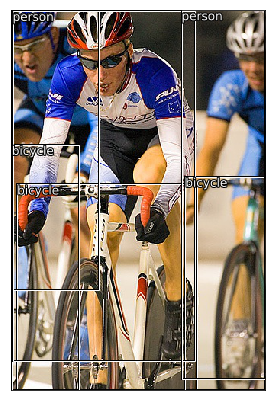

In [20]:
plot_img_bb(trn_ids[2])

## Largest object classifier

In [21]:
tmp = trn_bb[trn_ids[2]]

In [22]:
tmp

[(2, array([229,   8, 499, 244])),
 (2, array([219, 229, 499, 333])),
 (2, array([177,   1, 499,  89])),
 (15, array([  0,   1, 368, 116])),
 (15, array([  1,   2, 461, 242])),
 (15, array([  0, 224, 485, 333]))]

In [23]:
def get_largest(bbs):
    return sorted(bbs, key=lambda x: bb_hw(x[1])[2] * bb_hw(x[1])[3], reverse=True)[0]

In [24]:
trn_bb_lrg = {id: get_largest(trn_bb[id]) for id in trn_ids}

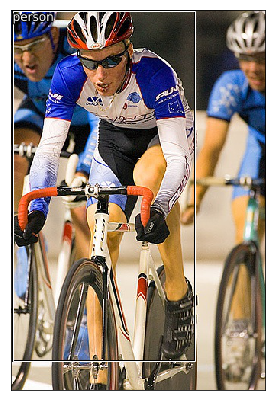

In [25]:
plot_img_bb(trn_ids[2], trn_bb_lrg)

In [26]:
lrg_df = pd.DataFrame(
    {'fn': [trn_fns[id] for id in trn_ids], 
     'cat': [cats[trn_bb_lrg[id][0]] for id in trn_ids]}, 
    columns = ['fn', 'cat'])

In [27]:
lrg_df.tail()

,fn,cat
2496,009944.jpg,motorbike
2497,009945.jpg,sheep
2498,009949.jpg,person
2499,009959.jpg,car
2500,009961.jpg,dog


In [28]:
lrg_df.to_csv(PATH / 'lrg_df.csv', index=False)

### Pretrained model

In [29]:
f_model = resnet34
sz = 224
bs=64

In [30]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)

In [31]:
md = ImageClassifierData.from_csv(PATH, 'JPEGImages', PATH/ 'lrg_df.csv', tfms=tfms)

In [32]:
x, y=next(iter(md.val_dl))

In [33]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

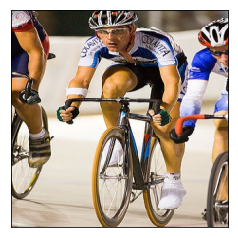

In [34]:
show_img(md.val_ds.denorm(to_np(x))[0]);

In [35]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])

In [36]:
learn.summary()

ValueError: Expected more than 1 value per channel when training, got input size [1, 1024]

In [235]:
learn.opt_fn = optim.Adam

In [236]:
lrf = learn.lr_find()

 91%|█████████ | 29/32 [00:20<00:02,  1.41it/s, loss=10.3]

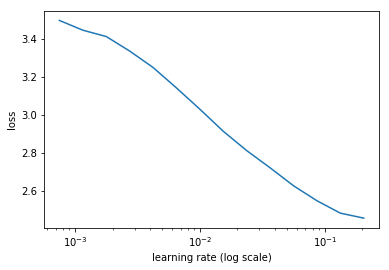

In [237]:
learn.sched.plot()

In [238]:
lr = 2e-2

In [241]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.307141   0.864851   0.761569  


[0.8648515, 0.761568509042263]

In [246]:
lrs = np.array([lr/1000,lr/100,lr])

In [247]:
learn.freeze_to(-2)

 84%|████████▍ | 27/32 [00:44<00:08,  1.63s/it, loss=4.63] 

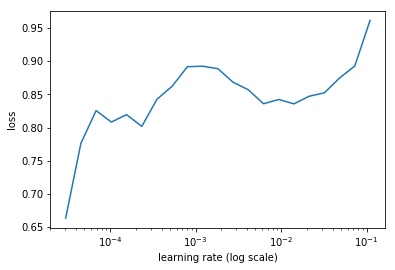

In [248]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [250]:
import tqdm

In [251]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.829375   0.744322   0.783504  


[0.74432206, 0.7835036069154739]

In [252]:
learn.unfreeze()

In [253]:
learn.fit(lrs/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.621855   0.808581   0.782602  
    1      0.459543   0.731533   0.803035                  


[0.73153293, 0.8030348569154739]

In [254]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 56

### Train from scratch

https://github.com/fastai/fastai/blob/master/courses/dl1/lesson7-cifar10.ipynb

In [35]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [36]:
class ConvBnNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i + 1])
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l in self.layers: x = l(x)
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [37]:
my_learn = ConvLearner.from_model_data(ConvBnNet([10, 20, 40, 80, 160], 10), md)

In [38]:
my_learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 10, 224, 224]),
                           ('trainable', True),
                           ('nb_params', 760)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 224, 224]),
                           ('output_shape', [-1, 20, 112, 112]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 224, 224]),
                           ('output_shape', [-1, 20, 112, 112]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 112, 112]),
                           ('output_shape', [-1, 40, 56, 56]),
                           ('trainable', True),
                           ('nb_params', 7200)])),
             ('BnLayer-5',
           

In [39]:
opt_fn = partial(optim.Adam)

In [40]:
my_learn.crit = F.nll_loss

In [41]:
my_learn.opt_fn = optim.Adam

In [42]:
import tqdm

In [43]:
my_learn.lr_find()

  0%|          | 0/32 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (59) : device-side assert triggered at /pytorch/torch/lib/THC/generic/THCTensorMath.cu:26